<a href="https://colab.research.google.com/github/jakartaresearch/adi-buzzer/blob/dev/notebook/R36_BPE_DL_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil --q
!pip install psutil --q
!pip install humanize --q

import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]

def printm():
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 12.7 GB  | Proc size: 111.8 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


In [2]:
# Mount Google Drive
from google.colab import drive # import drive from google colab

ROOT = "/content/drive/"     # default location for the drive
drive.mount(ROOT)           # we mount the google drive at /content/drive

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
!pip install bpemb

In [4]:
workdir_path = 'drive/My Drive/jakarta research/adi-buzzer/'

In [5]:
import time
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import torch
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from bpemb import BPEmb
from torch import tensor
from torch.utils.data import Dataset, DataLoader, RandomSampler
from torch.nn.utils.rnn import pad_sequence

% matplotlib inline
pd.set_option('precision', 2)

from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings('ignore', category=UndefinedMetricWarning)

## Prepare dataset and model

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [7]:
def load_data(path):
    data = pd.read_csv(path, keep_default_na=False)
    return data

def prepare_dataset(X_train_pth, y_train_pth, X_test_pth, y_test_pth):
    X_test = load_data(X_test_pth)
    y_test = load_data(y_test_pth)
    X_test.reset_index(drop=True, inplace=True)
    y_test.reset_index(drop=True, inplace=True)
    test = (X_test, y_test)

    X_tmp = load_data(X_train_pth)
    y_tmp = load_data(y_train_pth)
    X_train, X_val, y_train, y_val = train_test_split(X_tmp, y_tmp, test_size=0.2, random_state=42)
    X_train.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    X_val.reset_index(drop=True, inplace=True)
    y_val.reset_index(drop=True, inplace=True)

    train = (X_train, y_train)
    val = (X_val, y_val)
    return train, val, test

In [8]:
class DatasetBuzzer(Dataset):
    def __init__(self, data):
        self.data = data
        self.bpe = BPEmb(lang="id", vs=100000, dim=300)
        
    def __getitem__(self, idx):
        x_raw = self.data[0].loc[idx, 'text_used']
        y  = self.data[1].loc[idx, 'buzzer']
        
        x = self.bpe.encode_ids(x_raw)
        x = tensor(x)
        y = torch.LongTensor([y])
        
        return (x, y)
    
    def __len__(self):
        return len(self.data[0])

In [9]:
def padding(data):
    x_list = []
    y_list = []
    for x, y in data:
        x_list.append(x)
        y_list.append(y)
        
    x_pad = pad_sequence(x_list, batch_first=True)
    y_pad = pad_sequence(y_list, batch_first=True)
    
    return x_pad, y_pad

In [10]:
class LSTM(nn.Module):
    def __init__(self, hidden_size, num_class, weights):
        super(LSTM, self).__init__()
        self.word_embeddings = nn.Embedding.from_pretrained(weights)
        self.lstm = nn.LSTM(weights.shape[1], hidden_size, num_layers=1, dropout=0.5, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size, num_class)
        
    def forward(self, input_):
        input_ = self.word_embeddings(input_)
        out, (hidden_state, cell_state) = self.lstm(input_)
        out = self.fc(hidden_state[-1])
        
        return out

## Setup DataLoader

In [11]:
X_train_pth = workdir_path+'dataset/RAW_X_train.csv'
y_train_pth = workdir_path+'dataset/RAW_y_train.csv'
X_test_pth = workdir_path+'dataset/RAW_X_test.csv'
y_test_pth = workdir_path+'dataset/RAW_y_test.csv'

In [12]:
raw_train, raw_val, raw_test = prepare_dataset(X_train_pth, y_train_pth, X_test_pth, y_test_pth)

In [13]:
train_dataset = DatasetBuzzer(raw_train)
val_dataset = DatasetBuzzer(raw_val)
test_dataset = DatasetBuzzer(raw_test)

In [14]:
b_size = 32

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size = b_size, collate_fn=padding)
val_dataloader = DataLoader(val_dataset, shuffle=True, batch_size = b_size, collate_fn=padding)
test_dataloader = DataLoader(test_dataset, batch_size = b_size, collate_fn=padding)

In [15]:
print(f'total train batch: {len(train_dataloader)}')
print(f'total val batch: {len(val_dataloader)}')
print(f'total test batch: {len(test_dataloader)}')

total train batch: 60
total val batch: 15
total test batch: 19


## Hyperparameter and BPE Embeddings

In [16]:
weights = tensor(train_dataset.bpe.vectors)
hidden_size = 128
num_class = 2
epochs = 20

## Setup Model

In [17]:
model = LSTM(hidden_size, num_class, weights)
model.to(device)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


LSTM(
  (word_embeddings): Embedding(100000, 300)
  (lstm): LSTM(300, 128, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

In [18]:
parameters = sum(p.numel() for p in model.parameters())
print(f'model has {parameters:,} trainable parameters')

model has 30,440,578 trainable parameters


## Setup Optimizer and Loss function

In [19]:
optimizer = optim.AdamW(model.parameters())
criterion = nn.CrossEntropyLoss()

## Training and Validation model

In [20]:
def scoring(y_test, y_pred):
    acc = accuracy_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return acc, pre, rec, f1

In [21]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [22]:
def train_model(model, dataloader):
    running_train_loss = 0
    running_train_acc = 0
    running_train_pre = 0
    running_train_rec = 0
    running_train_f1 = 0
    
    ## Training mode
    n_batch = len(dataloader)
    t0 = time.time()
    model.train()
    for idx, (x, y) in tqdm(enumerate(dataloader, 1)):
        optimizer.zero_grad()
        x = x.to(device)
        y = y.squeeze().to(device)
        
        y_pred = model(x)
        loss = criterion(y_pred, y)
        
        y = y.cpu().numpy()
        y_pred = torch.max(y_pred, 1)[1].cpu().detach().numpy()
        acc, pre, rec, f1 = scoring(y, y_pred)

        running_train_loss += loss.item() * x.size(0)
        running_train_acc += acc
        running_train_pre += pre
        running_train_rec += rec
        running_train_f1 += f1

        loss.backward()
        optimizer.step()

    epoch_train_loss = running_train_loss / len(dataloader.dataset)
    epoch_train_acc = running_train_acc / n_batch
    epoch_train_pre = running_train_pre / n_batch
    epoch_train_rec = running_train_rec / n_batch
    epoch_train_f1 = running_train_f1 / n_batch
    
    train_time = time.time() - t0
    return epoch_train_loss, epoch_train_acc, epoch_train_pre, epoch_train_rec, epoch_train_f1, train_time

In [23]:
def eval_model(model, dataloader):
    running_val_loss = 0
    running_val_acc = 0
    running_val_pre = 0
    running_val_rec = 0
    running_val_f1 = 0
    
    ## Validation mode
    n_batch = len(dataloader)
    t0 = time.time()
    model.eval()
    with torch.no_grad():
        for idx, (x, y) in tqdm(enumerate(dataloader, 1)):
            x = x.to(device)
            y = y.squeeze().to(device)

            y_pred = model(x)
            loss = criterion(y_pred, y)
            
            y = y.cpu().numpy()
            y_pred = torch.max(y_pred, 1)[1].cpu().detach().numpy()
            acc, pre, rec, f1 = scoring(y, y_pred)

            running_val_loss += loss.item() * x.size(0)
            running_val_acc += acc
            running_val_pre += pre
            running_val_rec += rec
            running_val_f1 += f1
            
    epoch_val_loss = running_val_loss / len(dataloader.dataset)
    epoch_val_acc = running_val_acc / n_batch
    epoch_val_pre = running_val_pre / n_batch
    epoch_val_rec = running_val_rec / n_batch
    epoch_val_f1 = running_val_f1 / n_batch
    
    val_time = time.time() - t0
    return epoch_val_loss, epoch_val_acc, epoch_val_pre, epoch_val_rec, epoch_val_f1, val_time

In [24]:
training_stats = []
total_t0 = time.time()
for epoch_i in range(0, epochs):
    print(f'\n==== Epoch {epoch_i+1} / {epochs} ====')
    epoch_train_loss, epoch_train_acc, epoch_train_pre, epoch_train_rec, epoch_train_f1, train_time = train_model(model, train_dataloader)
    epoch_val_loss, epoch_val_acc, epoch_val_pre, epoch_val_rec, epoch_val_f1, val_time = eval_model(model, val_dataloader)

    training_stats.append({'Epoch': epoch_i + 1,
                           'Training Loss': epoch_train_loss,
                           'Validation Loss': epoch_val_loss,
                           'Training Accuracy': epoch_train_acc,
                           'Validation Accuracy': epoch_val_acc,
                           'Training Precision': epoch_train_pre,
                           'Validation Precision': epoch_val_pre,
                           'Training Recall': epoch_train_rec,
                           'Validation Recall': epoch_val_rec,
                           'Training F1': epoch_train_f1,
                           'Validation F1': epoch_val_f1
                           })

    print("\nTRAINING")
    print(f"Loss: {epoch_train_loss:.2f}  |  Accuracy: {epoch_train_acc:.2f}")
    print(f"Precision: {epoch_train_pre:.2f}  |  Recall: {epoch_train_rec:.2f}  |  F1: {epoch_train_f1:.2f}")
    print(f"Exec Time: {round(train_time)}s")
    print("\nEVALUATING")
    print(f"Loss: {epoch_val_loss:.2f}  |  Accuracy: {epoch_val_acc:.2f}")
    print(f"Precision: {epoch_val_pre:.2f}  |  Recall: {epoch_val_rec:.2f}  |  F1: {epoch_val_f1:.2f}")
    print(f"Exec Time: {round(val_time)}s")

print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

0it [00:00, ?it/s]


==== Epoch 1 / 20 ====


60it [00:34,  1.74it/s]
15it [00:04,  3.13it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.51  |  Accuracy: 0.78
Precision: 0.15  |  Recall: 0.03  |  F1: 0.05
Exec Time: 34s

EVALUATING
Loss: 0.45  |  Accuracy: 0.78
Precision: 0.49  |  Recall: 0.11  |  F1: 0.18
Exec Time: 5s

==== Epoch 2 / 20 ====


60it [00:34,  1.76it/s]
15it [00:04,  3.10it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.41  |  Accuracy: 0.83
Precision: 0.66  |  Recall: 0.39  |  F1: 0.46
Exec Time: 34s

EVALUATING
Loss: 0.42  |  Accuracy: 0.81
Precision: 0.65  |  Recall: 0.45  |  F1: 0.51
Exec Time: 5s

==== Epoch 3 / 20 ====


60it [00:35,  1.71it/s]
15it [00:04,  3.11it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.37  |  Accuracy: 0.85
Precision: 0.76  |  Recall: 0.53  |  F1: 0.59
Exec Time: 35s

EVALUATING
Loss: 0.44  |  Accuracy: 0.83
Precision: 0.71  |  Recall: 0.41  |  F1: 0.50
Exec Time: 5s

==== Epoch 4 / 20 ====


60it [00:35,  1.71it/s]
15it [00:04,  3.05it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.34  |  Accuracy: 0.86
Precision: 0.71  |  Recall: 0.55  |  F1: 0.60
Exec Time: 35s

EVALUATING
Loss: 0.43  |  Accuracy: 0.83
Precision: 0.76  |  Recall: 0.46  |  F1: 0.55
Exec Time: 5s

==== Epoch 5 / 20 ====


60it [00:34,  1.73it/s]
15it [00:04,  3.06it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.33  |  Accuracy: 0.86
Precision: 0.81  |  Recall: 0.50  |  F1: 0.59
Exec Time: 35s

EVALUATING
Loss: 0.46  |  Accuracy: 0.81
Precision: 0.76  |  Recall: 0.33  |  F1: 0.44
Exec Time: 5s

==== Epoch 6 / 20 ====


60it [00:34,  1.73it/s]
15it [00:04,  3.10it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.30  |  Accuracy: 0.88
Precision: 0.82  |  Recall: 0.59  |  F1: 0.66
Exec Time: 35s

EVALUATING
Loss: 0.45  |  Accuracy: 0.82
Precision: 0.63  |  Recall: 0.55  |  F1: 0.57
Exec Time: 5s

==== Epoch 7 / 20 ====


60it [00:34,  1.72it/s]
15it [00:04,  3.12it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.25  |  Accuracy: 0.91
Precision: 0.84  |  Recall: 0.70  |  F1: 0.75
Exec Time: 35s

EVALUATING
Loss: 0.47  |  Accuracy: 0.81
Precision: 0.62  |  Recall: 0.48  |  F1: 0.52
Exec Time: 5s

==== Epoch 8 / 20 ====


60it [00:34,  1.74it/s]
15it [00:04,  3.20it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.19  |  Accuracy: 0.93
Precision: 0.88  |  Recall: 0.77  |  F1: 0.80
Exec Time: 34s

EVALUATING
Loss: 0.54  |  Accuracy: 0.81
Precision: 0.65  |  Recall: 0.34  |  F1: 0.44
Exec Time: 5s

==== Epoch 9 / 20 ====


60it [00:34,  1.74it/s]
15it [00:04,  3.15it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.17  |  Accuracy: 0.94
Precision: 0.92  |  Recall: 0.80  |  F1: 0.84
Exec Time: 35s

EVALUATING
Loss: 0.58  |  Accuracy: 0.83
Precision: 0.67  |  Recall: 0.51  |  F1: 0.57
Exec Time: 5s

==== Epoch 10 / 20 ====


60it [00:34,  1.73it/s]
15it [00:04,  3.03it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.11  |  Accuracy: 0.96
Precision: 0.94  |  Recall: 0.84  |  F1: 0.88
Exec Time: 35s

EVALUATING
Loss: 0.65  |  Accuracy: 0.79
Precision: 0.54  |  Recall: 0.40  |  F1: 0.44
Exec Time: 5s

==== Epoch 11 / 20 ====


60it [00:34,  1.72it/s]
15it [00:04,  3.05it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.07  |  Accuracy: 0.98
Precision: 0.98  |  Recall: 0.94  |  F1: 0.95
Exec Time: 35s

EVALUATING
Loss: 0.75  |  Accuracy: 0.80
Precision: 0.63  |  Recall: 0.53  |  F1: 0.55
Exec Time: 5s

==== Epoch 12 / 20 ====


60it [00:33,  1.76it/s]
15it [00:04,  3.05it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.04  |  Accuracy: 0.99
Precision: 0.99  |  Recall: 0.99  |  F1: 0.99
Exec Time: 34s

EVALUATING
Loss: 0.81  |  Accuracy: 0.79
Precision: 0.60  |  Recall: 0.44  |  F1: 0.50
Exec Time: 5s

==== Epoch 13 / 20 ====


60it [00:34,  1.74it/s]
15it [00:04,  3.05it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.02  |  Accuracy: 1.00
Precision: 0.99  |  Recall: 0.99  |  F1: 0.99
Exec Time: 34s

EVALUATING
Loss: 0.96  |  Accuracy: 0.80
Precision: 0.62  |  Recall: 0.48  |  F1: 0.53
Exec Time: 5s

==== Epoch 14 / 20 ====


60it [00:35,  1.70it/s]
15it [00:04,  3.10it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.01  |  Accuracy: 1.00
Precision: 1.00  |  Recall: 0.99  |  F1: 0.99
Exec Time: 35s

EVALUATING
Loss: 1.08  |  Accuracy: 0.80
Precision: 0.60  |  Recall: 0.47  |  F1: 0.51
Exec Time: 5s

==== Epoch 15 / 20 ====


60it [00:34,  1.76it/s]
15it [00:04,  3.22it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.01  |  Accuracy: 1.00
Precision: 0.98  |  Recall: 0.98  |  F1: 0.98
Exec Time: 34s

EVALUATING
Loss: 1.18  |  Accuracy: 0.81
Precision: 0.67  |  Recall: 0.49  |  F1: 0.54
Exec Time: 5s

==== Epoch 16 / 20 ====


60it [00:35,  1.71it/s]
15it [00:04,  3.16it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.00  |  Accuracy: 1.00
Precision: 1.00  |  Recall: 1.00  |  F1: 1.00
Exec Time: 35s

EVALUATING
Loss: 1.25  |  Accuracy: 0.81
Precision: 0.62  |  Recall: 0.47  |  F1: 0.52
Exec Time: 5s

==== Epoch 17 / 20 ====


60it [00:34,  1.74it/s]
15it [00:04,  3.12it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.00  |  Accuracy: 1.00
Precision: 1.00  |  Recall: 1.00  |  F1: 1.00
Exec Time: 35s

EVALUATING
Loss: 1.26  |  Accuracy: 0.80
Precision: 0.63  |  Recall: 0.46  |  F1: 0.50
Exec Time: 5s

==== Epoch 18 / 20 ====


60it [00:34,  1.75it/s]
15it [00:04,  3.08it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.00  |  Accuracy: 1.00
Precision: 1.00  |  Recall: 1.00  |  F1: 1.00
Exec Time: 34s

EVALUATING
Loss: 1.32  |  Accuracy: 0.80
Precision: 0.62  |  Recall: 0.42  |  F1: 0.49
Exec Time: 5s

==== Epoch 19 / 20 ====


60it [00:34,  1.72it/s]
15it [00:04,  3.26it/s]
0it [00:00, ?it/s]


TRAINING
Loss: 0.00  |  Accuracy: 1.00
Precision: 1.00  |  Recall: 1.00  |  F1: 1.00
Exec Time: 35s

EVALUATING
Loss: 1.38  |  Accuracy: 0.80
Precision: 0.66  |  Recall: 0.44  |  F1: 0.50
Exec Time: 5s

==== Epoch 20 / 20 ====


60it [00:34,  1.72it/s]
15it [00:04,  3.04it/s]


TRAINING
Loss: 0.06  |  Accuracy: 0.98
Precision: 0.97  |  Recall: 0.96  |  F1: 0.96
Exec Time: 35s

EVALUATING
Loss: 0.76  |  Accuracy: 0.81
Precision: 0.61  |  Recall: 0.52  |  F1: 0.55
Exec Time: 5s
Training complete!
Total training took 0:13:10 (h:mm:ss)


In [25]:
# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('Epoch')

# Display the table.
df_stats

,Training Loss,Validation Loss,Training Accuracy,Validation Accuracy,Training Precision,Validation Precision,Training Recall,Validation Recall,Training F1,Validation F1
Epoch,,,,,,,,,,
1,5.14e-01,0.45,0.78,0.78,0.15,0.49,0.03,0.11,0.05,0.18
2,4.11e-01,0.42,0.83,0.81,0.66,0.65,0.39,0.45,0.46,0.51
3,3.68e-01,0.44,0.85,0.83,0.76,0.71,0.53,0.41,0.59,0.50
4,3.38e-01,0.43,0.86,0.83,0.71,0.76,0.55,0.46,0.60,0.55
5,3.35e-01,0.46,0.86,0.81,0.81,0.76,0.50,0.33,0.59,0.44
6,2.96e-01,0.45,0.88,0.82,0.82,0.63,0.59,0.55,0.66,0.57
7,2.46e-01,0.47,0.91,0.81,0.84,0.62,0.70,0.48,0.75,0.52
8,1.91e-01,0.54,0.93,0.81,0.88,0.65,0.77,0.34,0.80,0.44
9,1.73e-01,0.58,0.94,0.83,0.92,0.67,0.80,0.51,0.84,0.57


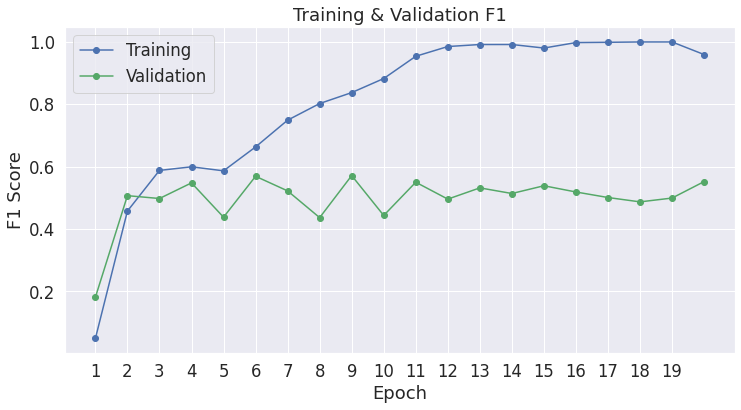

In [26]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training F1'], 'b-o', label="Training")
plt.plot(df_stats['Validation F1'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation F1")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.legend()
plt.xticks(np.arange(1, epochs))
plt.show()

In [27]:
print("Saving model to %s" % workdir_path)
torch.save(model.state_dict(), workdir_path+"buzzer_clf.pt")

Saving model to drive/My Drive/jakarta research/adi-buzzer/
